## Import data & split

In [1]:
# Import data from file downloaded from Kaggle
import pandas as pd
import numpy as np

# Load the MNIST dataset
mnist = pd.read_csv("./datasets/mnist_784.csv")

# Split the dataset into features and labels
# x contains the pixel values, and y contains the labels (0-9)
x, y = mnist.iloc[:, :-1].to_numpy(), mnist.iloc[:, -1].to_numpy()

In [2]:
# Breakup the data to training and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Exercise 1: Build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set.

### Method 1: Basic python

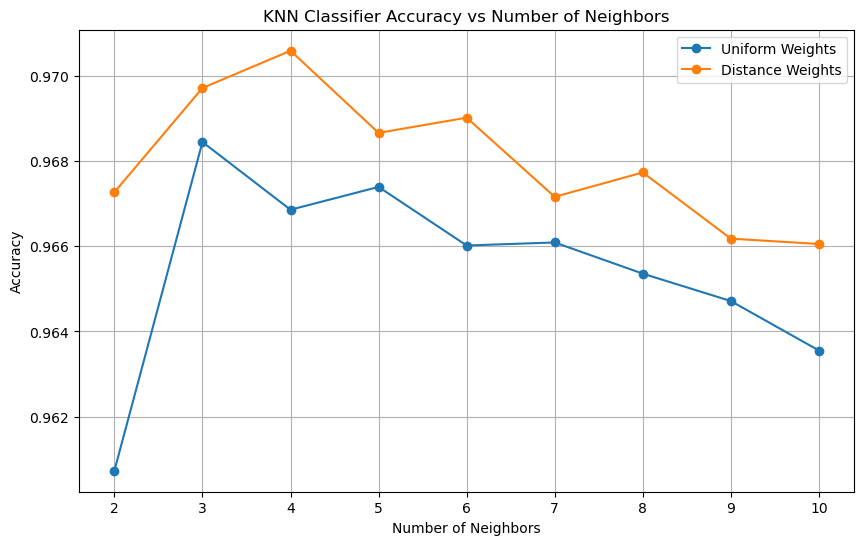

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


# Specifiy the number of neighbors to consider
n_num = np.array(range(2,11))

# Initialise lists to store the fitted models
uniform_fits = []
distance_fits = []

# Fit a KNN classifier, parrrelilizing the computation across all available CPU cores - 2
for i in n_num:
    knc = KNeighborsClassifier(n_neighbors=i, n_jobs=14, weights='uniform')
    knc.fit(x_train, y_train)
    uniform_fits.append(knc)

for i in n_num:
    knc = KNeighborsClassifier(n_neighbors=i, n_jobs=14, weights='distance')
    knc.fit(x_train, y_train)
    distance_fits.append(knc)


# Initalise list to store the accuracy scores
uniform_scores = []
distance_scores = []

# Evaluate the model using cross-validation, parrrelilizing the computation across all available CPU cores - 2
for knc in uniform_fits:
    scores = cross_val_score(knc, x_train, y_train, cv=3, n_jobs=14, scoring='accuracy')
    uniform_scores.append(scores.mean())

for knc in distance_fits:
    scores = cross_val_score(knc, x_train, y_train, cv=3, n_jobs=14, scoring='accuracy')
    distance_scores.append(scores.mean())

# Plot the accuracy scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(n_num, uniform_scores, label='Uniform Weights', marker='o')
plt.plot(n_num, distance_scores, label='Distance Weights', marker='o')
plt.title('KNN Classifier Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(n_num)
plt.legend()
plt.grid()
plt.show()

# 12m 37S to run on my machine

### Method 2: GridSearchCV

In [4]:
# Different approach using GridSearchCV to find the best hyperparameters, see if its faster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV


# Specifiy the hyperparameter values to consider
param_grid = [{"n_neighbors": list(range(2,11)), "weights":["uniform", "distance"]}]

# Initialise the KNN classifier and perform grid search with cross-validation
knn_clf = KNeighborsClassifier(n_jobs=14)
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, n_jobs=14, scoring='accuracy', verbose=3)
grid_search.fit(x_train, y_train)

# 11m 17s to run on my machine, about the same time

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=14), n_jobs=14,
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                          'weights': ['uniform', 'distance']}],
             scoring='accuracy', verbose=3)

In [5]:
# Print the best parameters, best score, and cross-validation results
print(grid_search.best_params_)

print(grid_search.best_score_)

print(grid_search.cv_results_)

{'n_neighbors': 4, 'weights': 'distance'}
0.9705892646492343
{'mean_fit_time': array([0.24962942, 0.25810917, 0.26085854, 0.26542505, 0.41657766,
       1.005639  , 1.17009528, 1.40136528, 1.23731891, 0.73205455,
       0.34343338, 0.96271785, 1.1730628 , 0.93016958, 0.55281409,
       0.47603822, 1.24263589, 1.18753664]), 'std_fit_time': array([0.03234478, 0.03988069, 0.03341035, 0.01866565, 0.24094463,
       0.08057554, 0.2739088 , 0.1745694 , 0.30295576, 0.10010556,
       0.09086464, 0.14315116, 0.1171659 , 0.41788866, 0.35830899,
       0.09132741, 0.12426117, 0.2774129 ]), 'mean_score_time': array([169.40344644, 164.23231808, 175.83589673, 166.22618906,
       189.38875572, 166.42616892, 172.28389637, 164.52924863,
       157.93478521, 168.56314754, 169.23205558, 166.05513167,
       171.20599286, 163.93478672, 145.52928193, 142.72006281,
       137.14148537, 128.90142337]), 'std_score_time': array([ 8.66757413,  6.33478684,  5.16977021,  7.42903592, 13.49353995,
        1.34356

## Exercise 2: Write a function that can shift an MNIST images in any direction by 1 pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set.

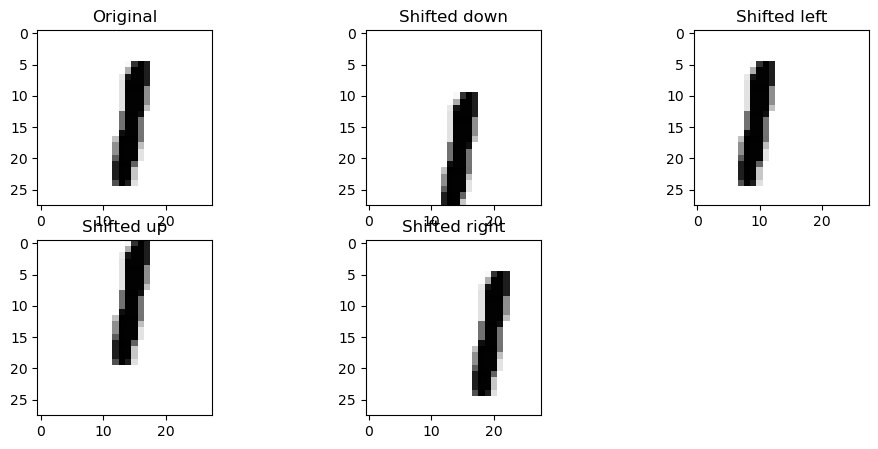

In [6]:
from scipy.ndimage import shift

# Function to shift an MNIST image in any direction by 1 pixel
def shift_image(image, direction, pixel=0):

    """
    Shift an MNIST image in the specified direction by a given number of pixels.

    :param      image (numpy.ndarray): The MNIST image to shift, should be a 1D array
    :param      direction (str): The direction to shift the image ('up', 'down', 'left', 'right')
    :param      pixel (int): The number of pixels to shift the image, default is 0
    :return     numpy.ndarray: The shifted image as a 1D array
    :raises     ValueError: If the direction is not one of 'up', 'down', 'left', 'right'
    :raises     TypeError: if the pixel is not an integer
    """

    if not isinstance(pixel, int):
        raise TypeError("Pixel value must be an integer")

    if direction == 'up':
        return shift(image.reshape(28, 28), (-pixel, 0), mode='constant').flatten()
    elif direction == 'down':
        return shift(image.reshape(28, 28), (pixel, 0), mode='constant').flatten()
    elif direction == 'left':
        return shift(image.reshape(28, 28), (0, -pixel), mode='constant').flatten()
    elif direction == 'right':
        return shift(image.reshape(28, 28), (0, pixel), mode='constant').flatten()
    else:
        raise ValueError("Direction must be one of: 'up', 'down', 'left', 'right'")


# Test the shift_image function with a sample image
import matplotlib.pyplot as plt

# Generate a sample image from the training set
image = x_train[500]  # some random digit to demo
shifted_image_down = shift_image(image, 'down', 5)
shifted_image_left = shift_image(image, 'left', 5)
shifted_image_up = shift_image(image, 'up', 5)
shifted_image_right = shift_image(image, 'right', 5)

# Display the original and shifted images
plt.figure(figsize=(12, 5))
plt.subplot(231)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.subplot(232)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.subplot(233)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.subplot(234)
plt.title("Shifted up")
plt.imshow(shifted_image_up.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.subplot(235)
plt.title("Shifted right")
plt.imshow(shifted_image_right.reshape(28, 28),
           interpolation="nearest", cmap="binary")
plt.show()



In [13]:
# Create shifted copies for each image in the training set
directions = ['up', 'down', 'left', 'right']
shifted_images = []
for image in x_train:
    for direction in directions:
        shifted_images.append(shift_image(image, direction, 1))

# Convert the list of shifted images to a numpy array
shifted_images = np.array(shifted_images)
# Combine the original training set with the shifted images
x_train_expanded = np.vstack((x_train, shifted_images))
# Combine the original labels with the labels for the shifted images
y_train_expanded = np.concatenate((y_train, np.repeat(y_train, len(directions))))


# Train the best model on the expanded training set
best_knn = grid_search.best_estimator_
best_knn.fit(x_train_expanded, y_train_expanded)
# Evaluate the model on the test set
test_accuracy = best_knn.score(x_test, y_test)
print(f"Test set accuracy after expanding training set: {test_accuracy:.2f}")

Test set accuracy after expanding training set: 0.98
